Object Detection with CNN Backbone

1.   Objective: Detect objects using bounding boxes.
2.   Dataset: Pascal VOC / COCO (subset).
3.   Key Tasks:


*   Use torchvision’s SSD or YOLO.

*   Annotate bounding boxes.
*   Evaluate mAP.







In [ ]:
!pip install torchaudio pycocotools torchmetrics matplotlib --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 51.4 MB/s eta 0:00:00


100%|██████████| 2.00G/2.00G [02:44<00:00, 12.2MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSDLite320_MobileNet_V3_Large_Weights.COCO_V1`. You can also use `weights=SSDLite320_MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/ssdlite320_mobilenet_v3_large_coco-a79551df.pth" to /root/.cache/torch/hub/checkpoints/ssdlite320_mobilenet_v3_large_coco-a79551df.pth
100%|██████████| 13.4M/13.4M [00:00<00:00, 150MB/s]


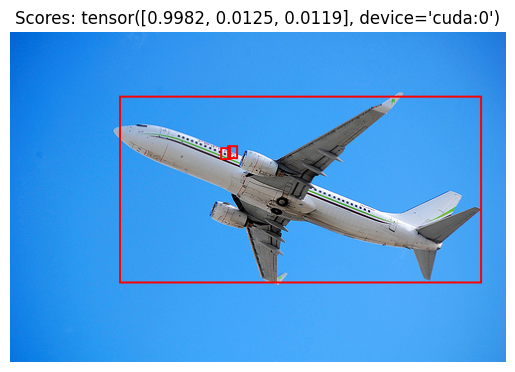

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


{'map': tensor(0.0694), 'map_50': tensor(0.1252), 'map_75': tensor(0.0861), 'map_small': tensor(0.0017), 'map_medium': tensor(0.0749), 'map_large': tensor(0.0803), 'mar_1': tensor(0.0294), 'mar_10': tensor(0.1118), 'mar_100': tensor(0.2118), 'mar_small': tensor(0.2000), 'mar_medium': tensor(0.2400), 'mar_large': tensor(0.2000), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 14, 15, 16, 17, 18, 19, 20, 21,
        22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 37, 38, 40, 41, 42, 43, 44,
        46, 47, 50, 51, 52, 53, 54, 57, 59, 60, 61, 62, 63, 64, 65, 67, 70, 72,
        73, 74, 75, 77, 78, 79, 81, 82, 84, 85, 86, 87, 88, 89, 90],
       dtype=torch.int32)}


In [ ]:
import torch
from torchvision.datasets import VOCDetection
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.models.detection import ssdlite320_mobilenet_v3_large
from torchvision.utils import draw_bounding_boxes
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

# Transform to convert PIL images to tensors
transform = T.Compose([T.ToTensor()])

# Load the VOC dataset
dataset = VOCDetection(root='.', year='2012', image_set='train', download=True, transform=transform)

# Helper function to format ground truth targets
def prepare_target(target):
    objects = target['annotation']['object']
    if not isinstance(objects, list):
        objects = [objects]
    boxes = []
    labels = []
    for obj in objects:
        bbox = obj['bndbox']
        xmin = float(bbox['xmin'])
        ymin = float(bbox['ymin'])
        xmax = float(bbox['xmax'])
        ymax = float(bbox['ymax'])
        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(1)  # Single class for simplicity
    return {
        'boxes': torch.tensor(boxes, dtype=torch.float32),
        'labels': torch.tensor(labels)
    }

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load pre-trained SSD model
model = ssdlite320_mobilenet_v3_large(pretrained=True)
model.eval().to(device)



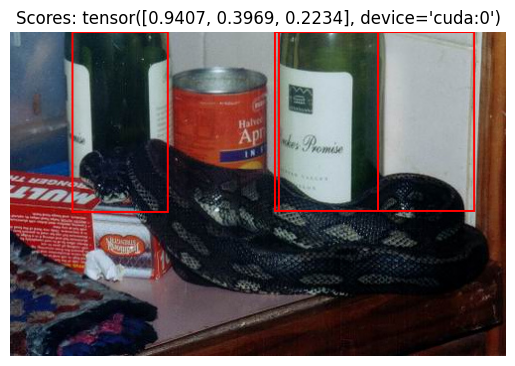

{'map': tensor(0.0694), 'map_50': tensor(0.1252), 'map_75': tensor(0.0861), 'map_small': tensor(0.0017), 'map_medium': tensor(0.0749), 'map_large': tensor(0.0803), 'mar_1': tensor(0.0294), 'mar_10': tensor(0.1118), 'mar_100': tensor(0.2118), 'mar_small': tensor(0.2000), 'mar_medium': tensor(0.2400), 'mar_large': tensor(0.2000), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 14, 15, 16, 17, 18, 19, 20, 21,
        22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 37, 38, 40, 41, 42, 43, 44,
        46, 47, 50, 51, 52, 53, 54, 57, 59, 60, 61, 62, 63, 64, 65, 67, 70, 72,
        73, 74, 75, 77, 78, 79, 81, 82, 84, 85, 86, 87, 88, 89, 90],
       dtype=torch.int32)}


In [ ]:
# Visualize predictions on one sample
img, target = dataset[1]
prepared_target = prepare_target(target)
img = img.to(device)

with torch.no_grad():
    prediction = model([img])[0]

# Draw top 3 predicted boxes
img_cpu = (img * 255).byte().cpu()
boxes = prediction['boxes'][:3]
scores = prediction['scores'][:3]
img_with_boxes = draw_bounding_boxes(img_cpu, boxes, colors="red", width=2)
plt.imshow(F.to_pil_image(img_with_boxes))
plt.title(f"Scores: {scores}")
plt.axis("off")
plt.show()

# Evaluate mAP over 20 samples
metric = MeanAveragePrecision()

for i in range(20):
    img, target = dataset[i]
    gt = prepare_target(target)
    img = img.to(device)
    with torch.no_grad():
        pred = model([img])[0]
    metric.update(
        [{
            "boxes": pred["boxes"].cpu(),
            "scores": pred["scores"].cpu(),
            "labels": pred["labels"].cpu()
        }],
        [{
            "boxes": gt["boxes"],
            "labels": gt["labels"]
        }]
    )

# Print final mAP result
print(metric.compute())
